# PQCs for evaluating $Q$-values

#### Imports

In [318]:
#General imports
import numpy as np
import matplotlib.pyplot as plt

#Operator Imports
from qiskit.aqua.operators import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.aqua.operators.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression

#Qiskit imports
import qiskit as qk
from qiskit.circuit.library import TwoLocal
import qiskit_machine_learning as qkml

# Fix seed for reproducibility
seed = 42
np.random.seed(42)

### Function declarations

##### `encoding_circuit`  

Function to load classical data (in our case the state/action of the agent and of its environment).

In [6]:
def encoding_circuit(inputs, num_qubits = 4, gate = 'rx', *args):
    """
    Encode classical input data on a quantum circuit. 
    
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    
    Return
    -------
    
    
    TODO:
    1. Add choice of encoding gate: ry, rz, or rx.
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i, data in enumerate(inputs): 
        qc.rx(data, i)
        
    return qc

#### `parametrized_circuit`  

Create the variational circuit (the PQC) by composing the encoding and a variational ansatze. It is possible to use data reuploading –loading the classical data multiple times throughout the circuit– to make the circuit more exxpressive and powerful.

In [175]:
def parametrized_circuit(inputs, num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It is the same reported in arXiv:2104.15084 (Skolik et al.).
    
    Args
    -------
    
    Return
    -------
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cx', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading: 
        
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cx(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cx(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # (Optional) Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc

#### The Parametrized Quantum Circuit (PQC)

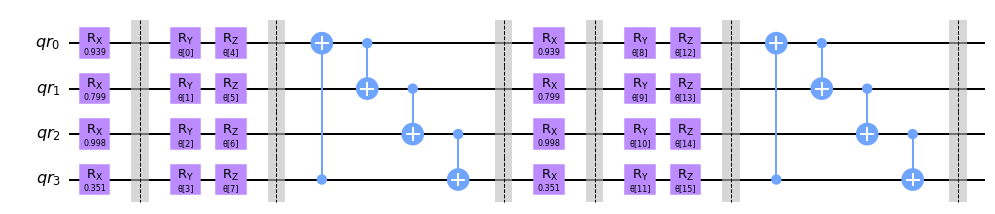

In [276]:
# Select the number of qubits
num_qubits = 4

# Generate some random inputs
inputs = np.random.rand(num_qubits)

# Generate the Parametrized Quantum Circuit (note the flag reuploading)
qc = parametrized_circuit(inputs, num_qubits = 4, reuploading = True)
qc.draw()

#### Binding parameters to some actual value (number)

Here's how it's done.

Random parameters:
 [0.767 0.402 0.48  0.628 0.874 0.984 0.768 0.418 0.421 0.738 0.239 0.11
 0.355 0.287 0.296 0.234] 

Circuit with randomly initialized parameters


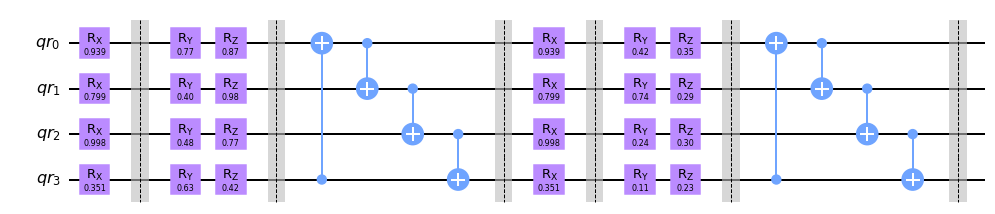

In [277]:
# Take the free variational parameters of the quantum circuit and put them in a list
params = list(qc.parameters)

# Generate some random values for the parameters
rand_params = np.round(np.random.rand(16),3).astype('float16')
print("Random parameters:\n", rand_params, "\n")

# Create a dictionary biding a parameter of the circuit to a random number just created
value_dict = {params[i]: rand_params[i] for i in range(qc.num_parameters)}

# Assign the values in the circuit
print("Circuit with randomly initialized parameters")
qca = qc.assign_parameters(value_dict)
qca.draw()

### Evaluate Gradients 

In this part we use the variational quantum circuit just introduced, and we evaluate the gradients wrt the parameters. 
That is we have an observable $O$ and we evaluate the derivative of such observable evaluated on the parametrized quantum state created by the variational circuit, that is:

$$
\frac{\partial \langle O \rangle_{\boldsymbol{\theta}}}{\partial \boldsymbol{\theta}} = \frac{\partial}{\partial \boldsymbol{\theta}}\langle \psi_\boldsymbol{\theta} | O |\psi_\boldsymbol{\theta}\rangle
$$

where $\boldsymbol{\theta}$ denotes the parameters in the PQC created above. There are multiple ways to do this, one of them being the *parameter shift role*.

In [278]:
# Define the Observable
O = Z ^ I ^ I ^ I
#  Examples of possible observavles
# O = 0.5 * Z -1 * X # scalar coefficients can be used
# O = X ^ I ^ Y      # '^' indicates the tensor product of observables acting on different qubits

# Combine the Observable and the variational state into an Expectation Value Operator
op = ~StateFn(O) @ CircuitStateFn(primitive=qc, coeff=1.)
print(op)

ComposedOp([
  OperatorMeasurement(ZIII),
  CircuitStateFn(
        ┌─────────────┐ ░ ┌──────────┐┌──────────┐ ░ ┌───┐                ░ »
  qr_0: ┤ RX(0.93907) ├─░─┤ RY(θ[0]) ├┤ RZ(θ[4]) ├─░─┤ X ├──■─────────────░─»
        ├─────────────┤ ░ ├──────────┤├──────────┤ ░ └─┬─┘┌─┴─┐           ░ »
  qr_1: ┤ RX(0.79878) ├─░─┤ RY(θ[1]) ├┤ RZ(θ[5]) ├─░───┼──┤ X ├──■────────░─»
        ├─────────────┤ ░ ├──────────┤├──────────┤ ░   │  └───┘┌─┴─┐      ░ »
  qr_2: ┤ RX(0.99793) ├─░─┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─░───┼───────┤ X ├──■───░─»
        ├─────────────┤ ░ ├──────────┤├──────────┤ ░   │       └───┘┌─┴─┐ ░ »
  qr_3: ┤ RX(0.35071) ├─░─┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─░───■────────────┤ X ├─░─»
        └─────────────┘ ░ └──────────┘└──────────┘ ░                └───┘ ░ »
  «      ┌─────────────┐ ░  ┌──────────┐┌───────────┐ ░ ┌───┐                ░ 
  «qr_0: ┤ RX(0.93907) ├─░──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├─░─┤ X ├──■─────────────░─
  «      ├─────────────┤ ░  ├──────────┤├───────────┤ ░ └─┬─┘┌─┴─┐           ░

In [279]:
# Convert the Expectation Value into an operator corresponding to the gradient w.r.t. the state parameters using
# the parameter shift method.
state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)

# Print the operator corresponding to the gradient
print(state_grad)

# Assign values to the parameters and evaluate the gradient
state_grad_result = state_grad.assign_parameters(value_dict).eval()
print('State gradient computed with parameter shift', state_grad_result)

ListOp([
  SummedOp([
    0.5 * ComposedOp([
      OperatorMeasurement(ZIII),
      CircuitStateFn(
            ┌─────────────┐ ░ ┌────────────────────────────┐┌──────────┐ ░ ┌───┐     »
      qr_0: ┤ RX(0.93907) ├─░─┤ RY(θ[0] + 1.5707963267949) ├┤ RZ(θ[4]) ├─░─┤ X ├──■──»
            ├─────────────┤ ░ └────────┬──────────┬────────┘├──────────┤ ░ └─┬─┘┌─┴─┐»
      qr_1: ┤ RX(0.79878) ├─░──────────┤ RY(θ[1]) ├─────────┤ RZ(θ[5]) ├─░───┼──┤ X ├»
            ├─────────────┤ ░          ├──────────┤         ├──────────┤ ░   │  └───┘»
      qr_2: ┤ RX(0.99793) ├─░──────────┤ RY(θ[2]) ├─────────┤ RZ(θ[6]) ├─░───┼───────»
            ├─────────────┤ ░          ├──────────┤         ├──────────┤ ░   │       »
      qr_3: ┤ RX(0.35071) ├─░──────────┤ RY(θ[3]) ├─────────┤ RZ(θ[7]) ├─░───■───────»
            └─────────────┘ ░          └──────────┘         └──────────┘ ░           »
      «                 ░ ┌─────────────┐ ░  ┌──────────┐┌───────────┐ ░ ┌───┐     »
      «qr_0: ───────────░─┤ RX(0

State gradient computed with parameter shift [(0.017260799134878768-5.9e-17j), (-0.2064307884883381-6.3e-17j), (-0.19215317084819944-6.25e-17j), (0.17693894149704187-1.9e-17j), (0.02336358171677344+1.5999999999999998e-17j), (-0.18762755481688811-3.5000000000000014e-18j), (-0.27948275929818955-9.000000000000001e-17j), (0.0018216493115890964-1.2000000000000001e-17j), (0.0038062532654891765-8.15e-17j), (-0.012884256032023783-2.35e-17j), (-0.13148763869260716+5.999999999999999e-18j), 1.1449999999999999e-16j, (-8.326672684688674e-17-7.3e-17j), -1.05e-17j, (2.7755575615628914e-17+1.05e-17j), (-5.551115123125783e-17-3.1000000000000005e-17j)]


Initial random parameters

In [280]:
print("Initial random parameters")
print(rand_params)

print("\nGradients of the parameters")
print(np.real(np.round(state_grad_result,3)))

print("\nUpdated parameters")
print(np.real(np.round(rand_params + state_grad_result, 3)))

Initial random parameters
[0.767 0.402 0.48  0.628 0.874 0.984 0.768 0.418 0.421 0.738 0.239 0.11
 0.355 0.287 0.296 0.234]

Gradients of the parameters
[ 0.017 -0.206 -0.192  0.177  0.023 -0.188 -0.279  0.002  0.004 -0.013
 -0.131  0.    -0.     0.     0.    -0.   ]

Updated parameters
[0.784 0.196 0.288 0.805 0.897 0.796 0.489 0.42  0.425 0.725 0.108 0.11
 0.355 0.287 0.296 0.234]


### Use in a Variational Quantum Algorithm

In [281]:
# Execution Imports
from qiskit import Aer
from qiskit.aqua import QuantumInstance

# Algorithm Imports
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import CG, ADAM, L_BFGS_B

from qiskit.aqua.operators import I, X, Z
from qiskit.circuit import QuantumCircuit, ParameterVector
from scipy.optimize import minimize

In [340]:
grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)

qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'),
                        shots=1,
                        seed_simulator=seed,
                        seed_transpiler=seed)

#Conjugate Gradient algorithm
optimizer = L_BFGS_B()

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Gradient callable
vqe = VQE(O, qc, optimizer=optimizer, gradient=grad, callback=store_intermediate_result)

result = vqe.run(qi_sv)

import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

print('\nOptimized Expectation Value:', result['optimal_value'])

{   'cost_function_evals': 391,
    'eigenstate': array([ 1.13716883e-06+2.18622125e-06j, -1.66902465e-06+1.22033249e-06j,
       -3.11896848e-06+3.69001257e-07j, -2.82828542e-06+1.03763861e-06j,
        2.16807817e-07+5.96097691e-07j,  8.58957781e-07-4.06775266e-07j,
       -3.70097627e-07+1.71571416e-06j, -3.64447081e-07+1.46721652e-06j,
        5.30456069e-01+2.35936106e-02j,  5.50410196e-01+1.07660050e-01j,
        4.02472526e-01-7.99793763e-02j,  1.10992265e-01-3.94281870e-01j,
       -1.24627946e-01+9.57537772e-02j, -1.40748552e-02-1.23993373e-01j,
       -6.87560736e-02-6.35747589e-03j, -1.28163109e-01-7.67616602e-02j]),
    'eigenvalue': (-0.9999999999280815+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[8]): -4.712394785863974,
                              ParameterVectorElement(θ[7]): -3.492314288097997,
                              ParameterVectorElement(θ[15]): 2.342596562912938,
                              ParameterVectorElement(θ[10]): -4.71239450859236,


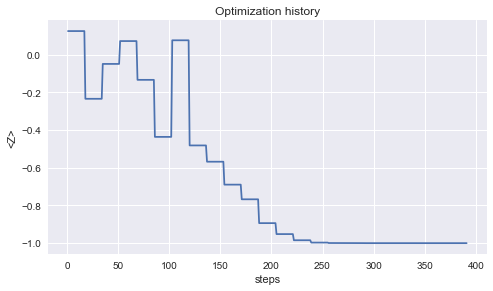

In [357]:
plt.style.use('seaborn')

fig = plt.figure(figsize=(7,4))

plt.plot(counts, values)

plt.title("Optimization history")
plt.ylabel("<Z>")
plt.xlabel("steps");

Try to substitute the optimized parameters in the circuit 

In [311]:
res_dict = result['optimal_parameters']

# Assign the values in the circuit
qca = qc.assign_parameters(res_dict)
# qca.measure_all()
qca.draw()

qasm_bknd = qk.Aer.get_backend("statevector_simulator")
counts = qk.execute(qca, backend = qasm_bknd, shots = 1000).result().get_counts()
print(counts)

{'0000': 6.98e-13, '0001': 2.8445e-11, '0010': 1.3006e-11, '0011': 2.7662e-11, '0100': 3.169e-12, '0101': 2.4303e-11, '0110': 2.187e-12, '0111': 2.863e-12, '1000': 4.9442e-11, '1001': 0.228228535775997, '1010': 7.449e-11, '1011': 0.228230221650335, '1100': 0.271771755549226, '1101': 2.18e-12, '1110': 0.27176948676877, '1111': 2.7228e-11}


The first qubit (the leftmost) is actually always in zero, correctly! The mean value of $\langle Z \rangle$ is given by

In [313]:
x = np.array(list(counts.values()))

# mZ = number of times is '0' - number of times is '1'
mZ = np.sum(x[0:8])-np.sum(x[8:16])

print("<Z> = ", mZ)

<Z> =  -0.9999999997953349
